---
# Pilot SRF

This notebook describes the first attempt with the hole-response experiment. The pipeline starts of after [call_lsprep](https://github.com/gjheij/linescanning/blob/main/bin/call_lsprep), which creates an `h5`-file with all relevant dataframes

In [1]:
from linescanning import (
    utils,
    dataset,
    fitting,
    plotting,
    glm,
    pycortex
)
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
opj = os.path.join

## Data loader

In [2]:
deriv = "/data1/projects/MicroFunc/Jurjen/projects/VE-SRF/derivatives"
subject = "sub-008"
# ribbon = (357,366)

# get h5-file
data_file = opj(deriv, "lsprep", subject, f"{subject}_ses-2_desc-preproc_bold.h5")

# load in
obj_ = dataset.Dataset(
    data_file,
    verbose=True
)

DATASET
Reading from /data1/projects/MicroFunc/Jurjen/projects/VE-SRF/derivatives/lsprep/sub-008/sub-008_ses-2_desc-preproc_bold.h5
 Set attribute: df_blinks
 Set attribute: df_func_ica
 Set attribute: df_func_psc
 Set attribute: df_func_raw
 Set attribute: df_onsets
 Could not set attribute 'df_saccades'
 Set attribute: df_space_eye
 Set attribute: df_space_func

DATASET: created


In [3]:
df_onsets = obj_.fetch_onsets()
df_func = obj_.fetch_fmri(dtype="raw")
df_filt = obj_.fetch_fmri(dtype="psc")

Fetching dataframe from attribute 'df_func_raw'
Fetching dataframe from attribute 'df_func_psc'


In [6]:
run_ids = obj_.get_runs(df_func)
ribbon = (357,366)
# df_rib = utils.select_from_df(df_func, expression="ribbon", indices=ribbon)
srfa = utils.select_from_df(df_func, expression="task = SRFa")
srfa

vox 0     vox 1     vox 2     vox 3     vox 4  \
subject task run t                                                           
008     SRFa 1   0.000    0.726162  1.162083  0.786618  1.087838  0.828084   
                 0.105    0.872089  0.594316  1.217380  1.085103  0.898678   
                 0.210    0.920771  0.934378  1.534020  1.649117  0.758136   
                 0.315    0.995827  0.640513  1.232167  1.660599  0.912393   
                 0.420    1.076918  0.716241  0.704553  1.160612  0.778854   
...                            ...       ...       ...       ...       ...   
             3   335.475  0.896548  0.821233  0.636603  0.736785  0.741450   
                 335.580  0.983653  0.565807  0.642752  0.614074  1.006382   
                 335.685  1.230451  0.640182  0.895030  0.596533  0.874168   
                 335.790  0.826123  0.797730  0.525442  0.586814  0.857589   
                 335.895  0.429523  0.784215  0.463826  0.797967  0.540644   

                             vox 5     vox 6     vox 7     vox 8     vox 9  \
subject task run t                                                           
008     SRFa 1   0.000    1.285420  0.527894  0.665945  0.806991  1.105380   
                 0.105    0.920400  1.387767  0.885629  1.258244  1.295973   
                 0.210    0.964682  0.945705  1.588733  0.634314  0.910209   
                 0.315    1.114072  1.039881  1.283864  0.740871  1.229057   
                 0.420    0.680483  1.431419  1.287013  1.193396  1.202211   
...                            ...       ...       ...       ...       ...   
             3   335.475  1.000375  1.044939  0.806430  0.643409  0.807104   
                 335.580  1.456362  0.891411  1.016672  0.477988  0.493888   
                 335.685  0.961823  0.742129  0.451413  0.806208  1.041163   
                 335.790  0.976153  0.419193  0.815180  0.759816  0.813493   
                 335.895  0.737750  1.365419  1.046015  1.051948  0.830288   

                          ...   vox 710   vox 711   vox 712   vox 713  \
subject task run t        ...                                           
008     SRFa 1   0.000    ...  1.030859  0.947152  0.923577  1.169941   
                 0.105    ...  0.920917  0.919716  1.159975  0.791347   
                 0.210    ...  0.790925  0.935573  1.058530  0.867279   
                 0.315    ...  0.979407  1.221434  1.066555  1.311566   
                 0.420    ...  1.288049  0.680640  0.860965  0.730688   
...                       ...       ...       ...       ...       ...   
             3   335.475  ...  0.491311  0.717196  0.464250  0.942884   
                 335.580  ...  0.709047  0.714553  0.634025  0.380161   
                 335.685  ...  0.672432  1.145962  0.641337  0.771472   
                 335.790  ...  0.503447  0.402495  0.645954  0.717078   
                 335.895  ...  0.908974  1.445259  0.349580  0.514396   

                           vox 714   vox 715   vox 716   vox 717   vox 718  \
subject task run t                                                           
008     SRFa 1   0.000    1.276008  0.718671  0.815843  1.053489  1.154642   
                 0.105    0.675950  1.197534  1.160235  1.072009  1.059933   
                 0.210    0.972927  1.274428  0.821537  1.208229  1.038283   
                 0.315    0.728297  0.817827  1.281277  0.826196  0.986594   
                 0.420    0.979834  1.188895  1.011306  0.835121  1.223650   
...                            ...       ...       ...       ...       ...   
             3   335.475  0.317521  1.118747  0.974353  0.572040  1.097908   
                 335.580  0.536523  0.455849  1.008219  1.400266  1.147815   
                 335.685  0.844698  0.567558  0.611057  0.487571  0.988906   
                 335.790  0.456381  0.856665  0.576106  0.754521  0.892988   
                 335.895  1.329306  0.571784  0.523398  1.052170  0.881155   

                           vox 719

In [7]:
%matplotlib inline
fig,axs = plt.subplots(ncols=len(run_ids), figsize=(24,6))
comb = list(itertools.combinations(run_ids, 2))
for ix,c in enumerate(comb):
    print(f"comparing run {c}")
    arr1 = utils.select_from_df(srfa, expression=f"run = {c[0]}").mean(axis=1)
    arr2 = utils.select_from_df(srfa, expression=f"run = {c[1]}").mean(axis=1)

    # corr = signal.correlate2d(
    #     arr1,
    #     arr2, 
    #     boundary='symm', 
    #     mode='same')

    plotting.LazyCorr(
        arr1,
        arr2, 
        axs=axs[ix], 
        title=f"run {c[0]} v {c[1]}", 
        scatter_kwargs={"alpha": 0.2})

fig.suptitle("cross-correlation", fontsize=32, y=1.05)
plt.show()

comparing run ('1', '2')
comparing run ('1', '3')
comparing run ('2', '3')


In [8]:
# average across runs within tasks
df_avg = df_func.groupby(["subject","task","t"]).mean()
df_avg

vox 0     vox 1     vox 2     vox 3     vox 4  \
subject task t                                                           
008     SRFa 0.000    0.759181  0.960950  0.688723  0.798920  0.575946   
             0.105    0.817075  1.000360  0.787289  0.989298  0.661384   
             0.210    0.852436  0.925343  0.911119  1.095364  0.779698   
             0.315    0.902616  0.915815  0.767497  1.155036  0.696892   
             0.420    0.822529  0.618377  0.733089  0.957597  0.784160   
...                        ...       ...       ...       ...       ...   
        SRFb 335.475  0.861532  0.989680  0.786871  0.881978  0.926702   
             335.580  1.036468  0.963364  0.786575  0.852501  0.764114   
             335.685  0.757503  0.824577  0.694650  0.877137  0.905316   
             335.790  0.714858  1.113610  0.664453  0.875722  0.748150   
             335.895  0.688318  0.720447  0.616831  0.774290  0.763080   

                         vox 5     vox 6     vox 7     vox 8     vox 9  ...  \
subject task t                                                          ...   
008     SRFa 0.000    0.903665  0.812378  0.868460  0.848813  0.741135  ...   
             0.105    0.844989  0.794133  0.764455  0.859597  0.844702  ...   
             0.210    0.921415  0.840003  1.034023  0.649305  0.712022  ...   
             0.315    0.792762  0.832149  1.018694  0.593821  0.972519  ...   
             0.420    0.885873  1.082555  1.009937  0.929583  0.937710  ...   
...                        ...       ...       ...       ...       ...  ...   
        SRFb 335.475  0.795196  0.628218  0.786170  0.618161  0.641540  ...   
             335.580  0.689814  0.843425  0.898005  0.794348  0.924771  ...   
             335.685  0.728983  0.891084  0.790187  0.786684  0.711919  ...   
             335.790  0.812498  0.825298  0.610042  0.691828  0.872574  ...   
             335.895  0.710727  0.785312  0.864610  0.913381  0.835548  ...   

                       vox 710   vox 711   vox 712   vox 713   vox 714  \
subject task t                                                           
008     SRFa 0.000    0.887349  0.640903  0.625430  0.906870  0.867371   
             0.105    0.798131  0.632454  0.770107  0.863494  0.782719   
             0.210    0.694372  0.729302  0.778148  0.770478  0.722936   
             0.315    0.882348  0.824022  1.008523  0.894001  0.698904   
             0.420    1.092574  0.723759  0.779314  0.714295  0.883583   
...                        ...       ...       ...       ...       ...   
        SRFb 335.475  0.899949  0.793809  0.728628  0.741482  0.913004   
             335.580  0.832819  0.680696  0.646148  0.702193  0.705645   
             335.685  0.812616  0.694212  0.773630  0.644837  0.860070   
             335.790  0.817131  0.750111  0.846032  0.724411  0.712557   
             335.895  0.769063  0.780550  0.619304  0.487719  0.774311   

                       vox 715   vox 716   vox 717   vox 718   vox 719  
subject task t                                                          
008     SRFa 0.000    0.753283  0.642404  0.769322  0.848749  0.813220  
             0.105    0.935163  0.756452  0.778002  0.749545  0.833753  
             0.210    0.979557  0.656592  0.959007  1.084041  0.973041  
             0.315    0.776834  0.941388  0.806905  0.947679  0.849389  
             0.420    0.857940  0.930051  0.666063  0.948344  0.831361  
...                        ...       ...       ...       ...       ...  
        SRFb 335.475  0.706627  0.769417  0.772194  0.641760  0.823340  
             335.580  0.922115  0.886545  0.645110  0.948512  0.920293  
             335.685  0.780925  0.657046  0.581778  0.921637  0.675241  
             335.790  0.833516  0.986513  0.839332  0.930611  0.816016  
             335.895  0.788204  0.927460  0.766386  0.817135  0.729434  

[6400 rows x 720 columns]

In [9]:
# select ribbon voxels
# ribbon = (346,359)
ribbon = (357,366)
df_ribbon = utils.select_from_df(df_avg, expression="ribbon", indices=ribbon)
df_ribbon

vox 357    vox 358    vox 359    vox 360    vox 361  \
subject task t                                                                
008     SRFa 0.000    23.868996  24.096939  23.529663  24.555998  25.845743   
             0.105    23.199417  24.482077  23.227213  24.208803  25.296118   
             0.210    26.004669  26.995531  25.832388  26.419014  27.211786   
             0.315    25.718527  26.573965  25.393705  26.604538  27.400579   
             0.420    25.109861  26.215614  25.195929  25.611404  26.710386   
...                         ...        ...        ...        ...        ...   
        SRFb 335.475  29.878761  27.803961  26.859488  26.860914  26.660675   
             335.580  29.255173  26.671301  26.967783  27.976049  26.452415   
             335.685  29.279551  27.816168  27.299498  27.404205  26.994547   
             335.790  29.805923  27.150833  27.510651  28.050657  26.566048   
             335.895  29.517090  27.684128  27.412226  27.720621  26.672907   

                        vox 362    vox 363    vox 364    vox 365  
subject task t                                                    
008     SRFa 0.000    25.514145  27.279236  28.892454  29.926699  
             0.105    25.238260  27.199310  28.173082  29.921089  
             0.210    26.411890  28.455065  29.891134  31.015732  
             0.315    26.680910  28.426554  29.679834  30.826975  
             0.420    25.802904  28.268038  29.317444  30.834524  
...                         ...        ...        ...        ...  
        SRFb 335.475  24.512068  28.226599  28.702423  30.961601  
             335.580  24.623329  27.903681  28.691412  29.936152  
             335.685  25.094549  28.263641  28.766493  30.558939  
             335.790  25.126839  28.487457  28.915339  30.595243  
             335.895  24.642385  28.319748  28.402288  30.690748  

[6400 rows x 9 columns]

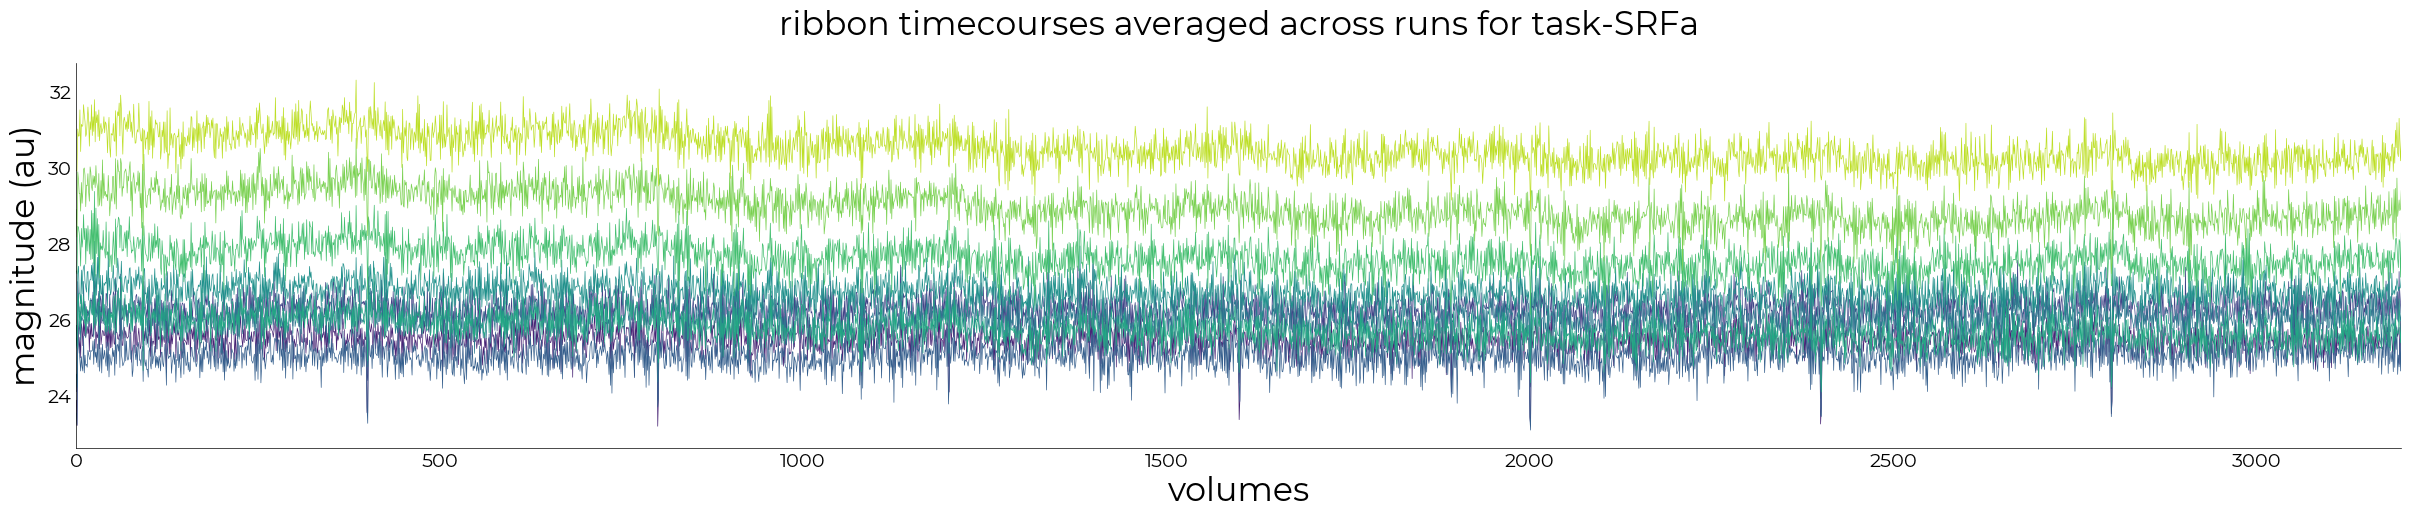

In [10]:
%matplotlib inline
# plot timecourses
task1_data = utils.select_from_df(df_ribbon, expression="task = SRFa")

plotting.LazyPlot(
    list(task1_data.T.to_numpy()),
    x_label="volumes",
    y_label="magnitude (au)",
    font_size=24,
    # add_hline="mean",
    line_width=0.5,
    title=f"ribbon timecourses averaged across runs for task-SRFa"
)

In [11]:
df_ribbon

vox 357    vox 358    vox 359    vox 360    vox 361  \
subject task t                                                                
008     SRFa 0.000    23.868996  24.096939  23.529663  24.555998  25.845743   
             0.105    23.199417  24.482077  23.227213  24.208803  25.296118   
             0.210    26.004669  26.995531  25.832388  26.419014  27.211786   
             0.315    25.718527  26.573965  25.393705  26.604538  27.400579   
             0.420    25.109861  26.215614  25.195929  25.611404  26.710386   
...                         ...        ...        ...        ...        ...   
        SRFb 335.475  29.878761  27.803961  26.859488  26.860914  26.660675   
             335.580  29.255173  26.671301  26.967783  27.976049  26.452415   
             335.685  29.279551  27.816168  27.299498  27.404205  26.994547   
             335.790  29.805923  27.150833  27.510651  28.050657  26.566048   
             335.895  29.517090  27.684128  27.412226  27.720621  26.672907   

                        vox 362    vox 363    vox 364    vox 365  
subject task t                                                    
008     SRFa 0.000    25.514145  27.279236  28.892454  29.926699  
             0.105    25.238260  27.199310  28.173082  29.921089  
             0.210    26.411890  28.455065  29.891134  31.015732  
             0.315    26.680910  28.426554  29.679834  30.826975  
             0.420    25.802904  28.268038  29.317444  30.834524  
...                         ...        ...        ...        ...  
        SRFb 335.475  24.512068  28.226599  28.702423  30.961601  
             335.580  24.623329  27.903681  28.691412  29.936152  
             335.685  25.094549  28.263641  28.766493  30.558939  
             335.790  25.126839  28.487457  28.915339  30.595243  
             335.895  24.642385  28.319748  28.402288  30.690748  

[6400 rows x 9 columns]

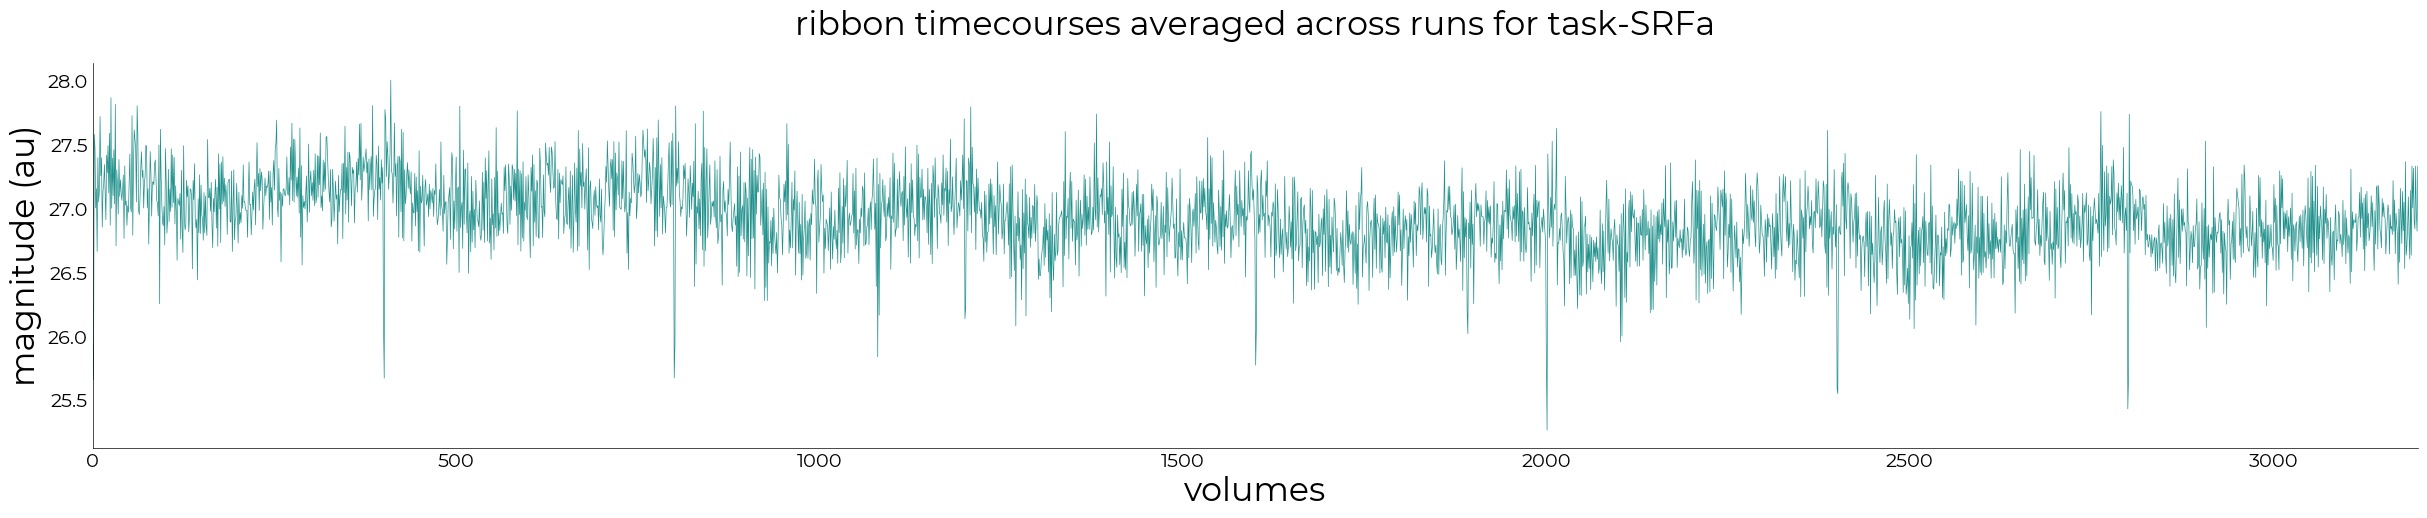

In [12]:
# select ribbon voxels
df_ribbon_avg = pd.DataFrame(df_ribbon.mean(axis=1), columns=["average"])
df_ribbon_avg

# plot timecourses
task1_avg = utils.select_from_df(df_ribbon_avg, expression="task = SRFa")

plotting.LazyPlot(
    list(task1_avg.T.to_numpy()),
    x_label="volumes",
    y_label="magnitude (au)",
    font_size=24,
    # add_hline=0,
    line_width=0.5,
    title=f"ribbon timecourses averaged across runs for task-SRFa"
)

In [13]:
# switch our task-ID for run-IDs so we can flop everything in nideconv
renamed_func = []
renamed_onsets = []

task_onsets = utils.select_from_df(df_onsets, expression="event_type != response")
for ix,task in enumerate(["SRFa","SRFb"]):
    
    # sort out func
    df = utils.select_from_df(df_ribbon_avg, expression=f"task = {task}").reset_index()
    df["run"] = ix+1
    df = df.drop("task", axis=1)
    renamed_func.append(df)

    # sort out onsets
    df = utils.select_from_df(task_onsets, expression=(f"task = {task}","&","run = 1")).reset_index()
    df["run"] = ix+1
    df = df.drop("task", axis=1)
    renamed_onsets.append(df)

renamed_func = pd.concat(renamed_func).set_index(["subject","run","t"])
renamed_onsets = pd.concat(renamed_onsets).set_index(["subject","run","event_type"])
renamed_func

average
subject run t                 
008     1   0.000    25.945541
            0.105    25.660597
            0.210    27.581913
            0.315    27.478401
            0.420    27.007345
...                        ...
        2   335.475  27.829611
            335.580  27.608589
            335.685  27.941956
            335.790  28.023220
            335.895  27.895792

[6400 rows x 1 columns]

## t-stats from 3D-EPI

In [87]:
# find cope files
zstats = []
for ii in range(2):
    z_file = opj(
        deriv,
        "feat",
        "level2",
        f"{subject}_desc-level1_confs.gfeat",
        f"{subject}_ses-2_task-SRF_space-fsnative_hemi-LR_desc-cope{ii+1}.npy"
        )
    
    if os.path.exists(z_file):
        zstats.append(z_file)
    else:
        raise FileNotFoundError(f"Could not find file '{z_file}'")
zstats

['/data1/projects/MicroFunc/Jurjen/projects/VE-SRF/derivatives/feat/level2/sub-008_desc-level1_confs.gfeat/sub-008_ses-2_task-SRF_space-fsnative_hemi-LR_desc-cope1.npy',
 '/data1/projects/MicroFunc/Jurjen/projects/VE-SRF/derivatives/feat/level2/sub-008_desc-level1_confs.gfeat/sub-008_ses-2_task-SRF_space-fsnative_hemi-LR_desc-cope2.npy']

In [94]:
# create objects
z1_data = np.load(zstats[0])
z2_data = np.load(zstats[1])

z1_pos = np.zeros_like(z1_data)
z1_pos[z1_data > 2.3] = z1_data[z1_data>2.3]

z2_neg = np.zeros_like(z2_data)
z2_neg_mask = np.zeros_like(z2_data)
z2_neg[z2_data<-2.3] = z2_data[z2_data<-2.3]
z2_neg_mask[z2_data<-2.3] = 1

z1_pos_v = pycortex.Vertex2D_fix(
    z1_pos,
    subject=subject,
    cmap="inferno",
    vmin1=2.3,
    vmax1=8
)

z2_neg_v = pycortex.Vertex2D_fix(
    z2_neg,
    subject=subject,
    data2=z2_neg_mask,
    cmap="cool",
    vmin1=-8,
    vmax1=-2.3
)

# target vertex
target = 11253
target_data = np.zeros_like(z1_data)
target_data[target] = 1
target_v = pycortex.Vertex2D_fix(
    target_data, 
    subject=subject, 
    cmap="magma")

# beam image
beam = opj(os.path.dirname(zstats[0]), f"{subject}_ses-2_task-SRF_space-fsnative_hemi-LR_desc-beam.npy")
beam_data = np.load(beam)
beam_v = pycortex.Vertex2D_fix(
    beam_data, 
    subject=subject, 
    cmap="magma")

In [97]:
# read prf estimates
prf_dir = opj(deriv, "prf", subject, "ses-1")
pyc = pycortex.SavePycortexViews(
    {
        "act": z1_pos_v,
        "neg": z2_neg_v,
        "beam": beam_v,
        "target": target_v
    },
    subject=subject,
    radius=240,
    azimuth=200,
    altitude=118,
    pivot=0,
    clicker="plot",
    transpose=True,
    prf_file=opj(prf_dir, f"{subject}_ses-1_task-2R_model-norm_stage-iter_desc-prf_params.pkl"),
    func_data=opj(prf_dir, f"{subject}_ses-1_task-2R_hemi-LR_desc-avg_bold.npy"),
    dm=opj(prf_dir, "design_task-2R.mat"),
    rh=0,
    verbose=False)

Started server on port 34828


saving act
saving neg
saving beam
saving target
saving /data1/projects/MicroFunc/Jurjen/projects/VE-SRF/derivatives/feat/level2/sub-008_desc-level1_confs.gfeat/sub-008_desc-brainmaps.pdf


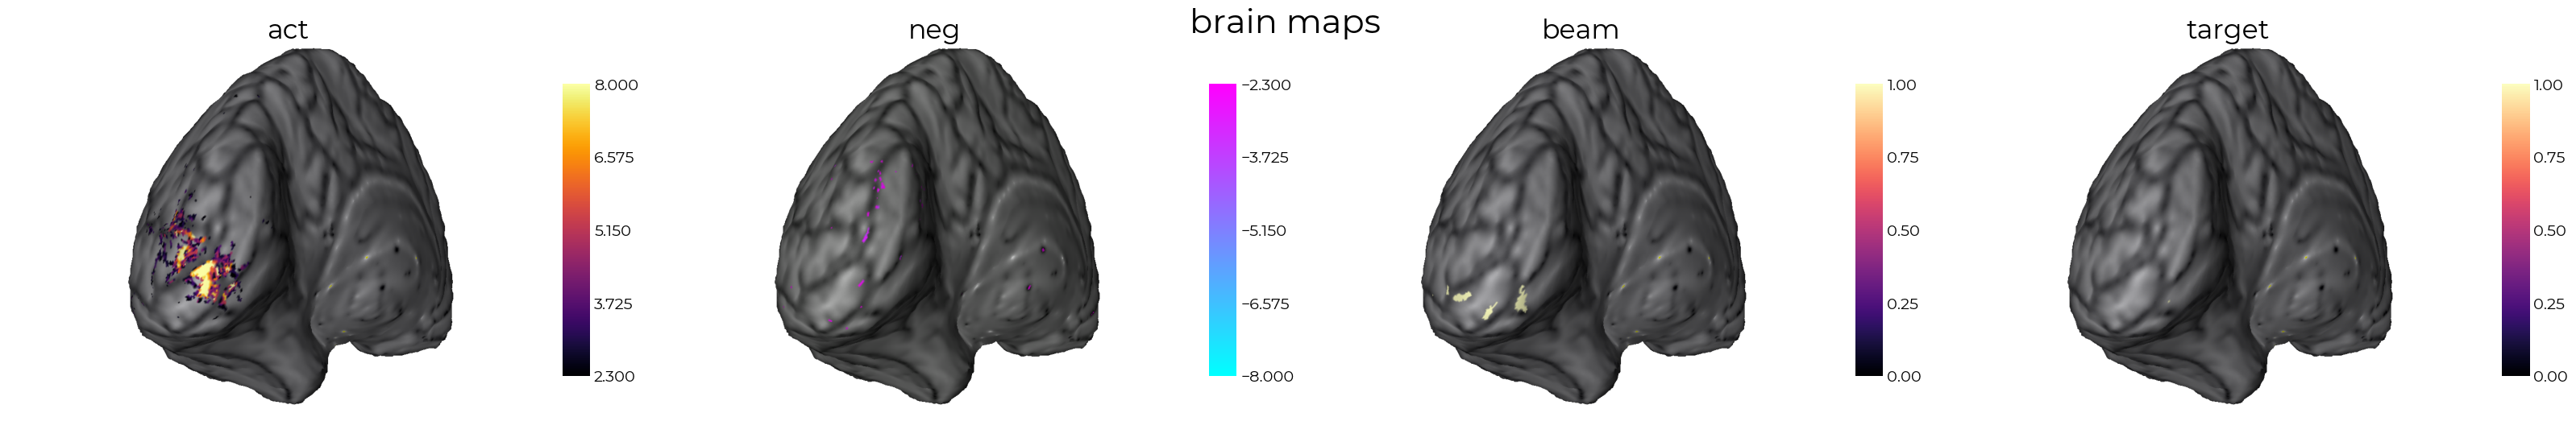

In [101]:
pyc.save_all(
    fig_dir=os.path.dirname(zstats[0]),
    gallery=True,
    add_cms=True,
    n_cols=4,
    cb=[200,1000,350,1500]
)

In [49]:
%matplotlib
pyc.fig

Using matplotlib backend: nbAgg


<IPython.core.display.Javascript object>

## GLM

In [71]:
from linescanning import preproc
r1_data = utils.select_from_df(renamed_func, expression="run = 1")

hp_data, _cosine_drift = preproc.highpass_dct(
    r1_data.T.values,
    0.01,
    TR=0.105
)

lp_data = preproc.lowpass_savgol(
    r1_data.T.values,
    window_length=71,
    polyorder=3
)

hp_lp_data = preproc.lowpass_savgol(
    hp_data,
    window_length=71,
    polyorder=3
)

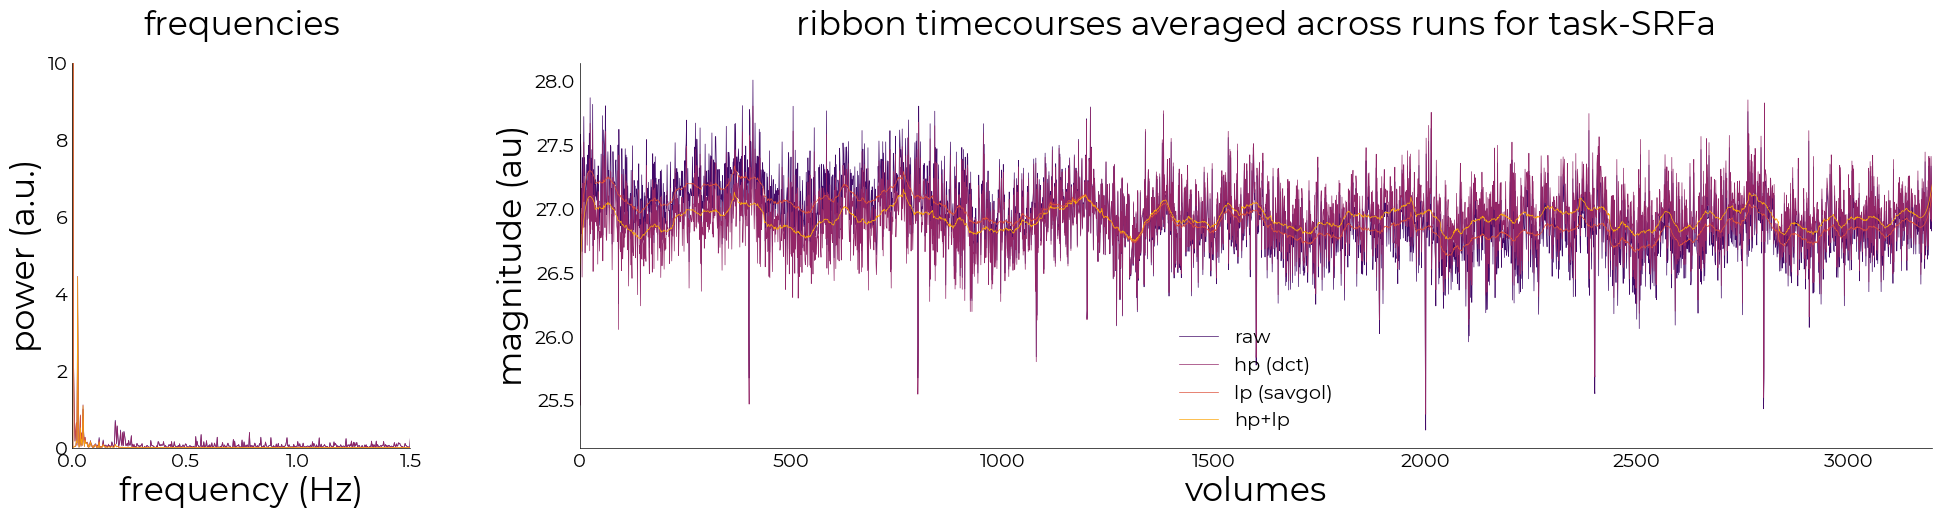

In [72]:
tc_raw = r1_data.values.squeeze()
tc_hp = hp_data.squeeze()
tc_lp = lp_data.squeeze()
tc_hlp = hp_lp_data.squeeze()

# collect power spectra
freqs = []
tcs = [tc_raw,tc_hp,tc_lp,tc_hlp]
lbls = ["raw", "hp (dct)","lp (savgol)","hp+lp"]
for tc in tcs:

    # freq
    tc_freq = preproc.get_freq(tc, TR=0.105, spectrum_type='fft')

    # append
    freqs.append(tc_freq)         

# create figure
fig,axs = plt.subplots(ncols=2, figsize=(24,5), gridspec_kw={"width_ratios": [0.2,0.8]})
colors = ["#cccccc","r"]
lws = 0.5
fs = 24

plotting.LazyPlot(
    [freqs[ii][1] for ii in range(len(tcs))],
    xx=freqs[0][0],
    x_label="frequency (Hz)",
    y_label="power (a.u.)",
    title="frequencies",
    axs=axs[0],
    x_lim=[0,1.5],
    line_width=lws,
    font_size=fs,
    # color=colors,
    cmap="inferno",
    y_lim=[0,10]) 


# plot timecourses
plotting.LazyPlot(
    tcs,
    axs=axs[1],
    x_label="volumes",
    y_label="magnitude (au)",
    font_size=fs,
    # add_hline=0,
    line_width=lws,
    # color=colors,
    cmap="inferno",
    labels=lbls,
    title=f"ribbon timecourses averaged across runs for task-SRFa"
)

In [16]:
c_vec1 = [0,1,1,0,0]
c_vec2 = [0,0,0,1,1]
c_vec3 = [0,1,1,1,1]

c_vec = np.array([c_vec1,c_vec2,c_vec3])
c_vec.shape

(3, 5)

### GLM - raw data, no cosines

In [19]:
fitter = glm.GenericGLM(
    utils.select_from_df(renamed_onsets, expression="run = 1"), 
    tc_raw,
    hrf_pars="glover",
    derivative=True,
    TR=0.105, 
    osf=100, 
    verbose=True)

Defining HRF with option 'glover'
Creating stimulus vector(s)
Convolve stimulus vectors with HRF
Resample convolved stimulus vectors


t-stat [0. 1. 1. 0. 0.]: [1.1855172]
t-stat [0. 0. 0. 1. 1.]: [-2.29128002]
t-stat [0. 1. 1. 1. 1.]: [-0.27745948]


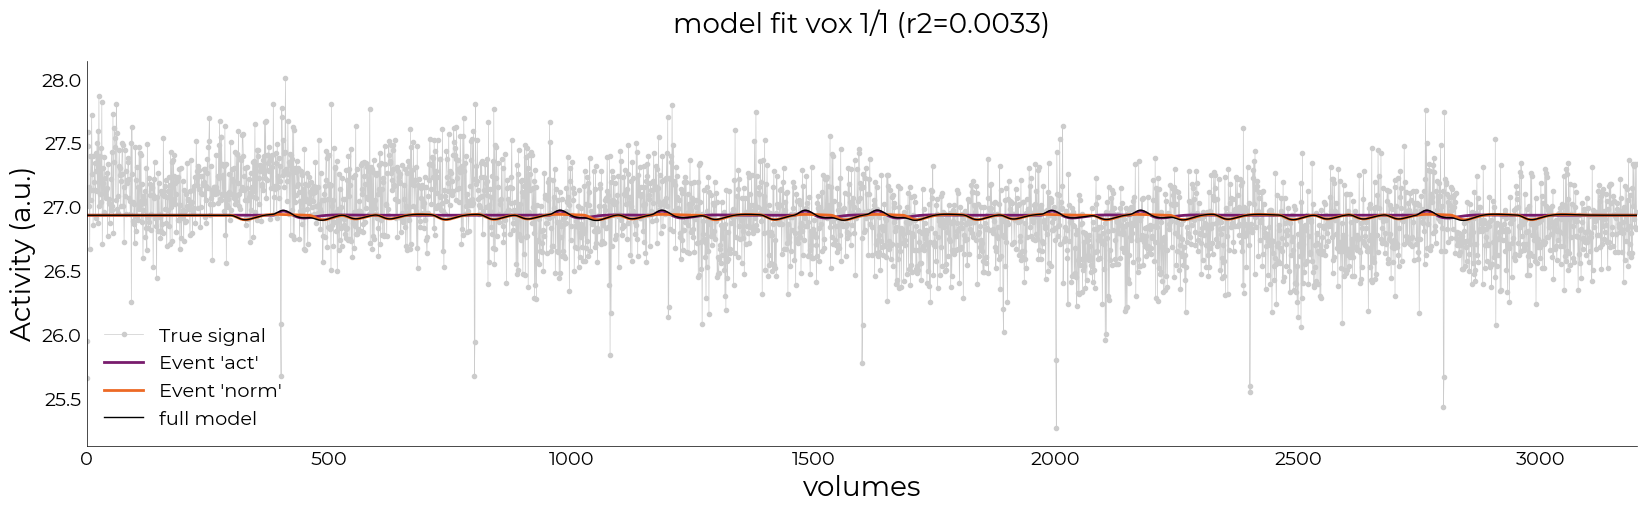

In [124]:
fitter.create_design()
fitter.fit(
    make_figure=True, 
    copes=c_vec, 
    verbose=True, 
    plot_full=True)
t_pre = fitter.results["tstats"]

### GLM - raw data, with cosines

t-stat [0. 1. 1. 0. 0. 0. 0. 0. 0. 0.]: [2.94069845]
t-stat [0. 0. 0. 1. 1. 0. 0. 0. 0. 0.]: [-0.74829555]
t-stat [0. 1. 1. 1. 1. 0. 0. 0. 0. 0.]: [1.68972979]


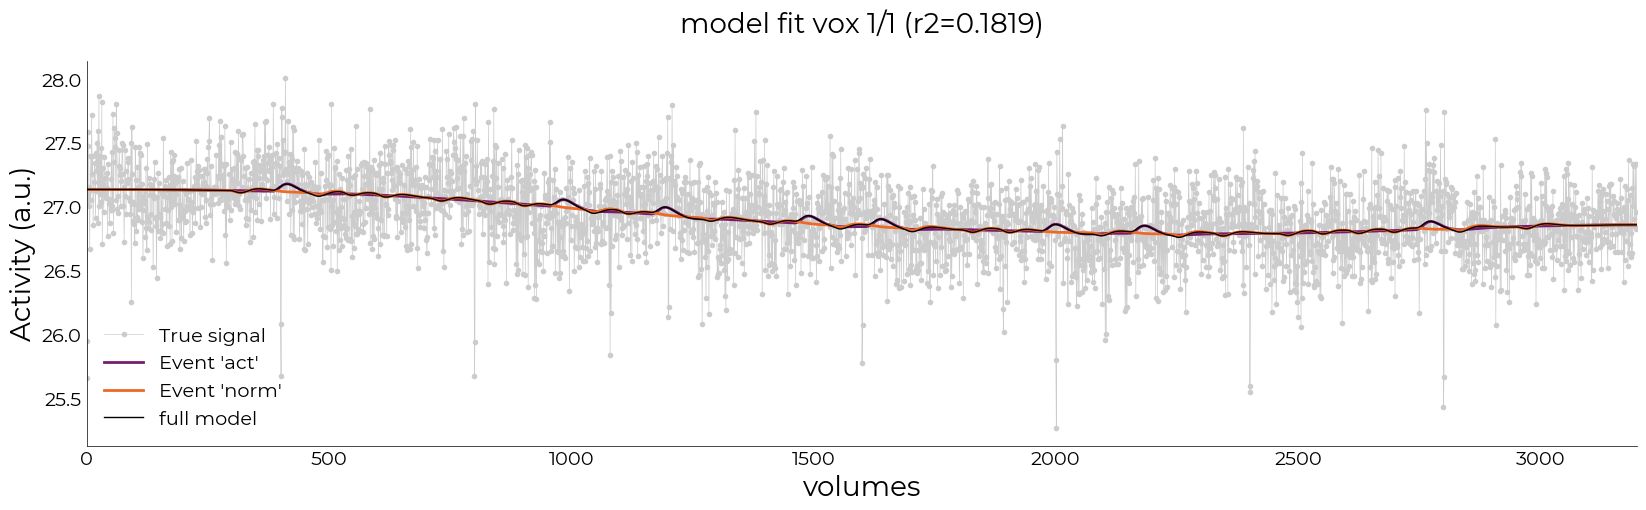

In [123]:
fitter.create_design(regressors=_cosine_drift[:,:-1])
fitter.fit(
    make_figure=True, 
    copes=c_vec, 
    verbose=True, 
    plot_full=True)
t_cos = fitter.results["tstats"]

### GLM - high-pass data (no cosines)

In [25]:
fitter_hp = glm.GenericGLM(
    utils.select_from_df(renamed_onsets, expression="run = 1"), 
    tc_hp,
    hrf_pars="glover",
    derivative=True,
    TR=0.105, 
    osf=100, 
    verbose=True)

Defining HRF with option 'glover'
Creating stimulus vector(s)
Convolve stimulus vectors with HRF
Resample convolved stimulus vectors


t-stat [0. 1. 1. 0. 0.]: [2.79232896]
t-stat [0. 0. 0. 1. 1.]: [-1.1213141]
t-stat [0. 1. 1. 1. 1.]: [1.43083382]


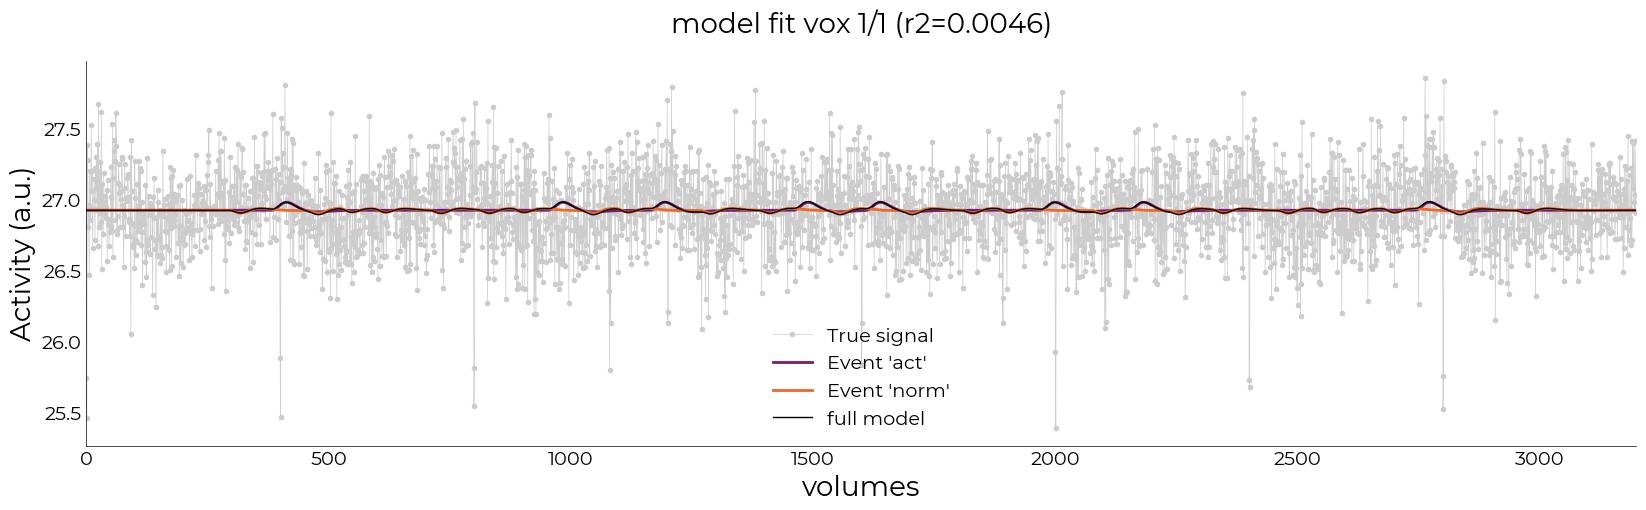

In [122]:
fitter_hp.create_design()
fitter_hp.fit(
    make_figure=True, 
    copes=c_vec, 
    verbose=True, 
    plot_full=True)
t_hp = fitter_hp.results["tstats"]

### GLM - low-pass data (no cosines)

In [103]:
fitter_lp = glm.GenericGLM(
    utils.select_from_df(renamed_onsets, expression="run = 1"), 
    tc_lp,
    hrf_pars="glover",
    derivative=True,
    TR=0.105, 
    osf=100, 
    verbose=True)

Defining HRF with option 'glover'
Creating stimulus vector(s)
Convolve stimulus vectors with HRF
Resample convolved stimulus vectors


t-stat [0. 1. 1. 0. 0.]: [2.58973255]
t-stat [0. 0. 0. 1. 1.]: [-4.06953823]
t-stat [0. 1. 1. 1. 1.]: [-0.14993591]


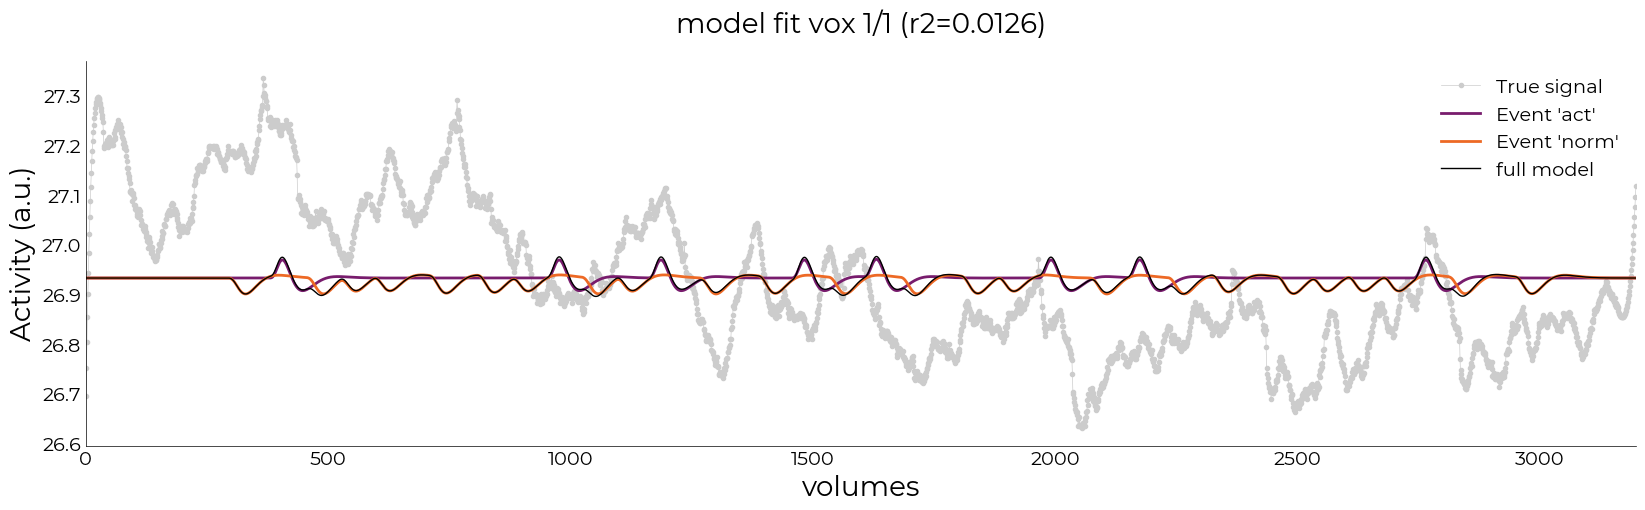

In [108]:
fitter_lp.create_design()
fitter_lp.fit(
    make_figure=True, 
    copes=c_vec, 
    verbose=True, 
    plot_full=True)
t_lp = fitter_lp.results["tstats"]

### GLM - low-pass data (with cosines)

t-stat [0. 1. 1. 0. 0. 0. 0. 0. 0. 0.]: [10.55006982]
t-stat [0. 0. 0. 1. 1. 0. 0. 0. 0. 0.]: [-1.57434437]
t-stat [0. 1. 1. 1. 1. 0. 0. 0. 0. 0.]: [6.60347369]


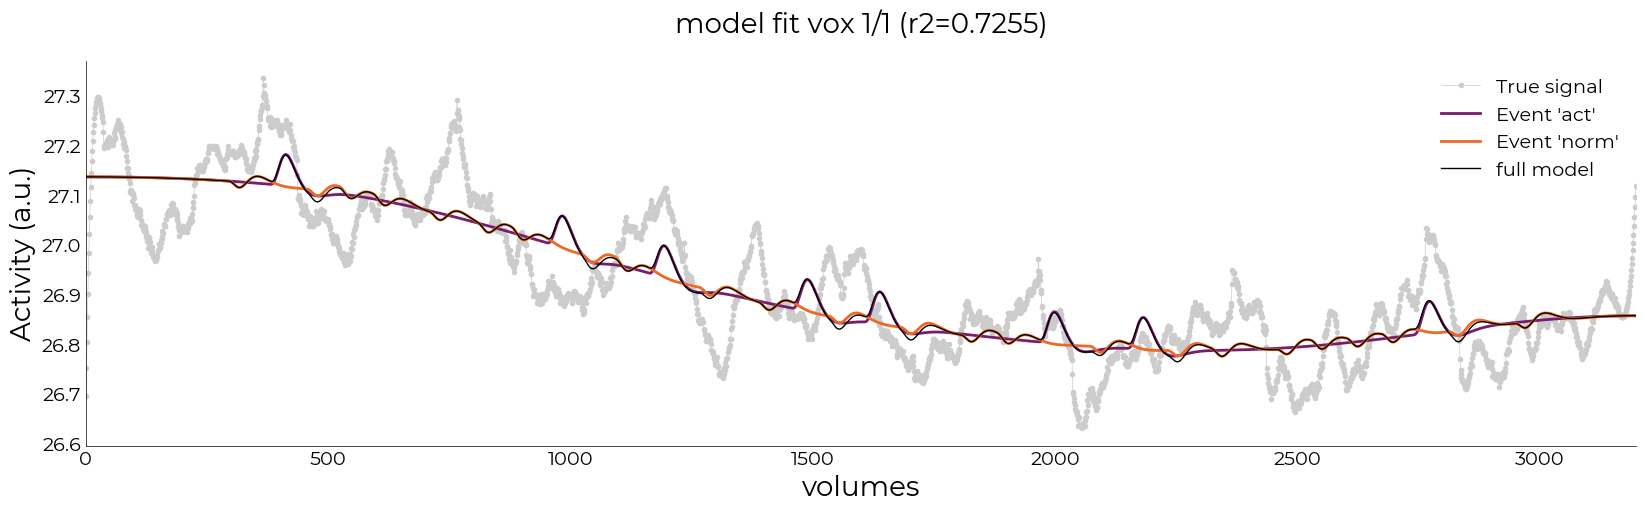

In [109]:
fitter_lp.create_design(regressors=_cosine_drift[:,:-1])
fitter_lp.fit(
    make_figure=True, 
    copes=c_vec, 
    verbose=True, 
    plot_full=True)
t_lp_cos = fitter_lp.results["tstats"]

### GLM - high+low-pass data (no cosines)

In [110]:
fitter_hlp = glm.GenericGLM(
    utils.select_from_df(renamed_onsets, expression="run = 1"), 
    tc_hlp,
    hrf_pars="glover",
    derivative=True,
    TR=0.105, 
    osf=100, 
    verbose=True)

Defining HRF with option 'glover'
Creating stimulus vector(s)
Convolve stimulus vectors with HRF
Resample convolved stimulus vectors


In [112]:
fitter_hlp.create_design()
fitter_hlp.fit(
    make_figure=True, 
    copes=c_vec, 
    verbose=True, 
    plot_full=True)
t_hlp = fitter_hlp.results["tstats"]

t-stat [0. 1. 1. 0. 0.]: [10.05631464]
t-stat [0. 0. 0. 1. 1.]: [-2.88120196]
t-stat [0. 1. 1. 1. 1.]: [5.71711904]


### GLM - ribbon data

In [121]:
df_rib = utils.select_from_df(df_ribbon, expression="task = SRFa")

In [114]:
fit_rib = glm.GenericGLM(
    utils.select_from_df(renamed_onsets, expression="run = 1"), 
    df_rib,
    hrf_pars="glover",
    derivative=True,
    TR=0.105, 
    osf=100, 
    verbose=True)

Defining HRF with option 'glover'
Creating stimulus vector(s)
Convolve stimulus vectors with HRF
Resample convolved stimulus vectors


t-stat [0. 1. 1. 0. 0. 0. 0. 0. 0. 0.]: [ 0.01600468 -0.07889073 -0.78141862  2.45181414  2.45906275  3.33817577
  4.42628107  4.50145135  2.83098696]
t-stat [0. 0. 0. 1. 1. 0. 0. 0. 0. 0.]: [-0.34195855  0.3040912  -1.92259841 -0.43383898 -0.52620189 -0.94977607
  0.46441974 -0.41788214 -1.18105401]
t-stat [0. 1. 1. 1. 1. 0. 0. 0. 0. 0.]: [-0.15556653  0.09316383 -1.48347887  1.50149196  1.46151766  1.86919332
  3.31903775  2.94132247  1.4020507 ]


(3, 9)

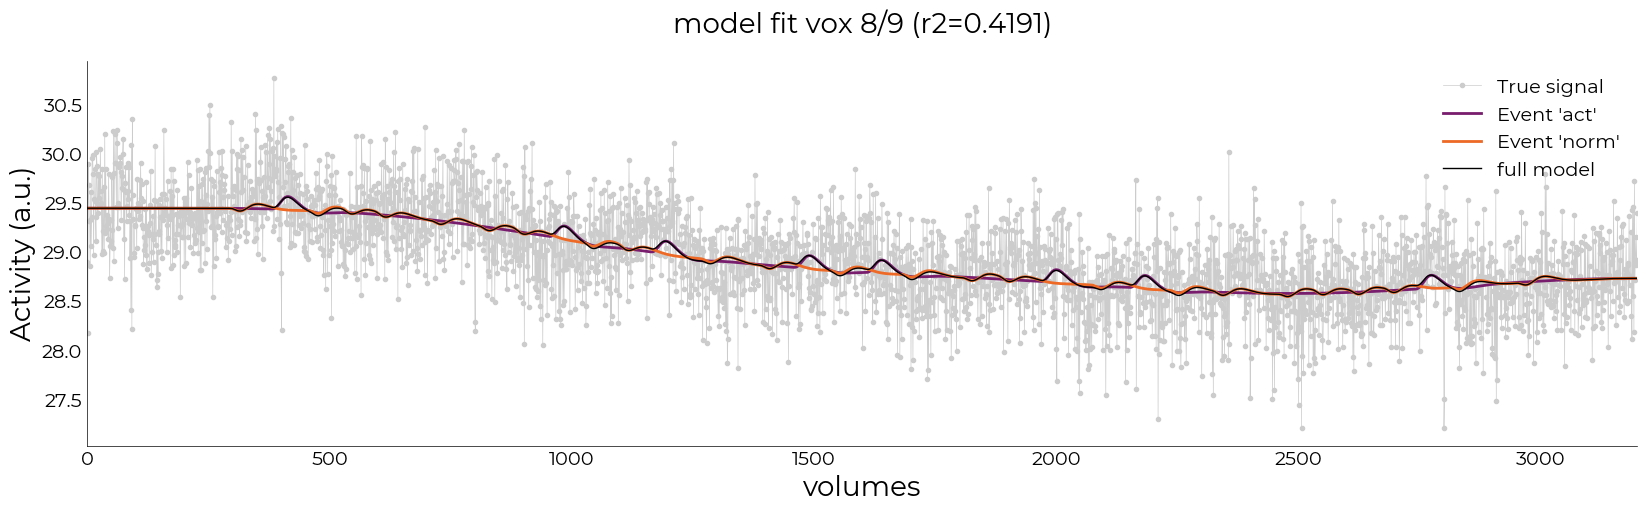

In [116]:
fit_rib.create_design(regressors=_cosine_drift[:,:-1])
fit_rib.fit(
    make_figure=True, 
    copes=c_vec, 
    verbose=True, 
    plot_full=True)

t_rib = fit_rib.results["tstats"]
t_rib.shape

### GLM - full line

In [120]:
df_avg_filt = df_filt.groupby(["subject","task","t"]).mean()
df_line = utils.select_from_df(df_avg_filt, expression=f"task = SRFa")

In [118]:
fit_line = glm.GenericGLM(
    utils.select_from_df(renamed_onsets, expression="run = 1"), 
    df_line,
    hrf_pars="glover",
    derivative=True,
    TR=0.105, 
    osf=100, 
    verbose=True)

Defining HRF with option 'glover'
Creating stimulus vector(s)
Convolve stimulus vectors with HRF
Resample convolved stimulus vectors


In [119]:
fit_line.create_design()
fit_line.fit(
    make_figure=True, 
    copes=c_vec, 
    # verbose=False, 
    plot_full=True)

t_line = fit_line.results["tstats"]
t_line.shape

(3, 720)

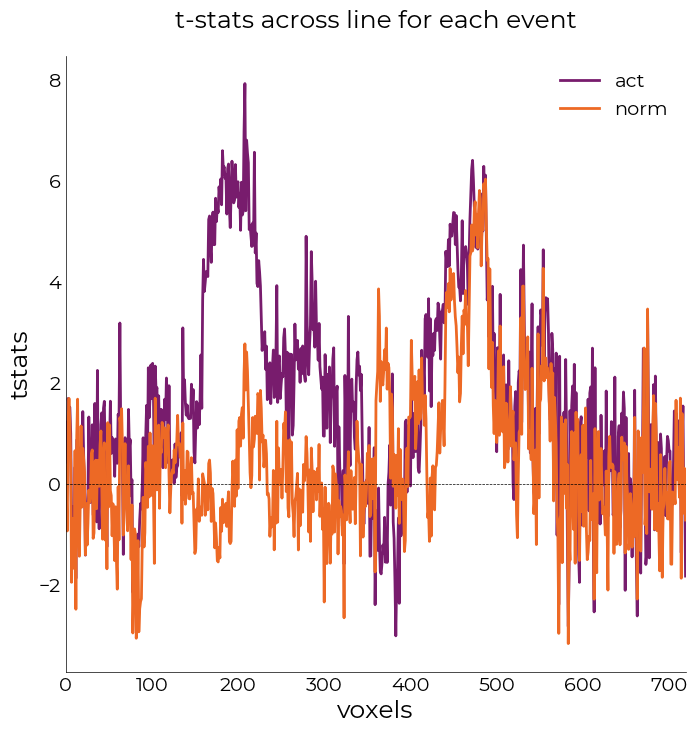

In [31]:
plotting.LazyPlot(
    [t_line[i+1] for i,_ in enumerate(fit_line.plot_event)],
    figsize=(8,8),
    x_label="voxels",
    y_label="tstats",
    labels=fit_line.plot_event,
    line_width=2,
    cmap="inferno",
    add_hline=0,
    title="t-stats across line for each event"
)

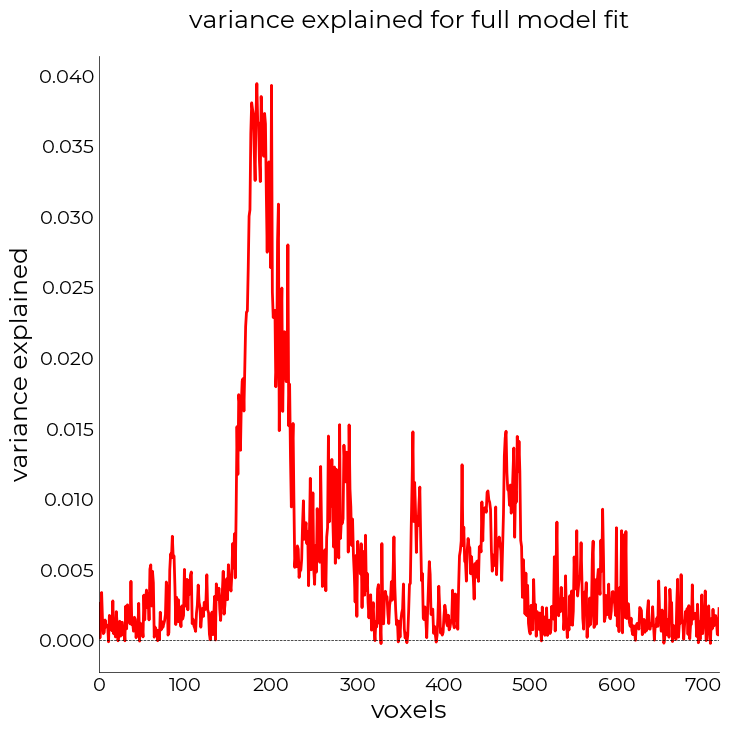

In [93]:
plotting.LazyPlot(
    fit_line.results["r2"],
    figsize=(8,8),
    x_label="voxels",
    y_label="variance explained",
    line_width=2,
    color="r",
    title="variance explained for full model fit",
    add_hline=0
)

## Deconvolve

In [28]:
# fit events on averaged data
can_fit = fitting.NideconvFitter(
    renamed_func,
    renamed_onsets,
    basis_sets='canonical_hrf_with_time_derivative',
    # n_regressors=4,
    TR=0.105,
    interval=[-3,25],
    add_intercept=True,
    verbose=True,
    fit=True)

# fit events on averaged data
fou_fit = fitting.NideconvFitter(
    renamed_func,
    renamed_onsets,
    basis_sets='fourier',
    n_regressors=2,
    TR=0.105,
    interval=[-3,25],
    add_intercept=True,
    verbose=True,
    fit=True)


Selected 'canonical_hrf_with_time_derivative'-basis sets
Adding event 'act' to model
Adding event 'norm' to model
Fitting with 'ols' minimization
Done
Selected 'fourier'-basis sets
Adding event 'act' to model
Adding event 'norm' to model
Fitting with 'ols' minimization
Done


In [29]:
# # fit button response on single run data
# response_onsets = utils.select_from_df(df_onsets, expression="event_type = response")
# fit_button = fitting.NideconvFitter(
#     df_func,
#     response_onsets,
#     basis_sets='fourier',
#     n_regressors=9,
#     TR=0.105,
#     interval=[-3,17],
#     add_intercept=True,
#     verbose=True,
#     fit=True)

# fit_button.timecourses_condition()

## Plotting

### Average over ribbon voxels

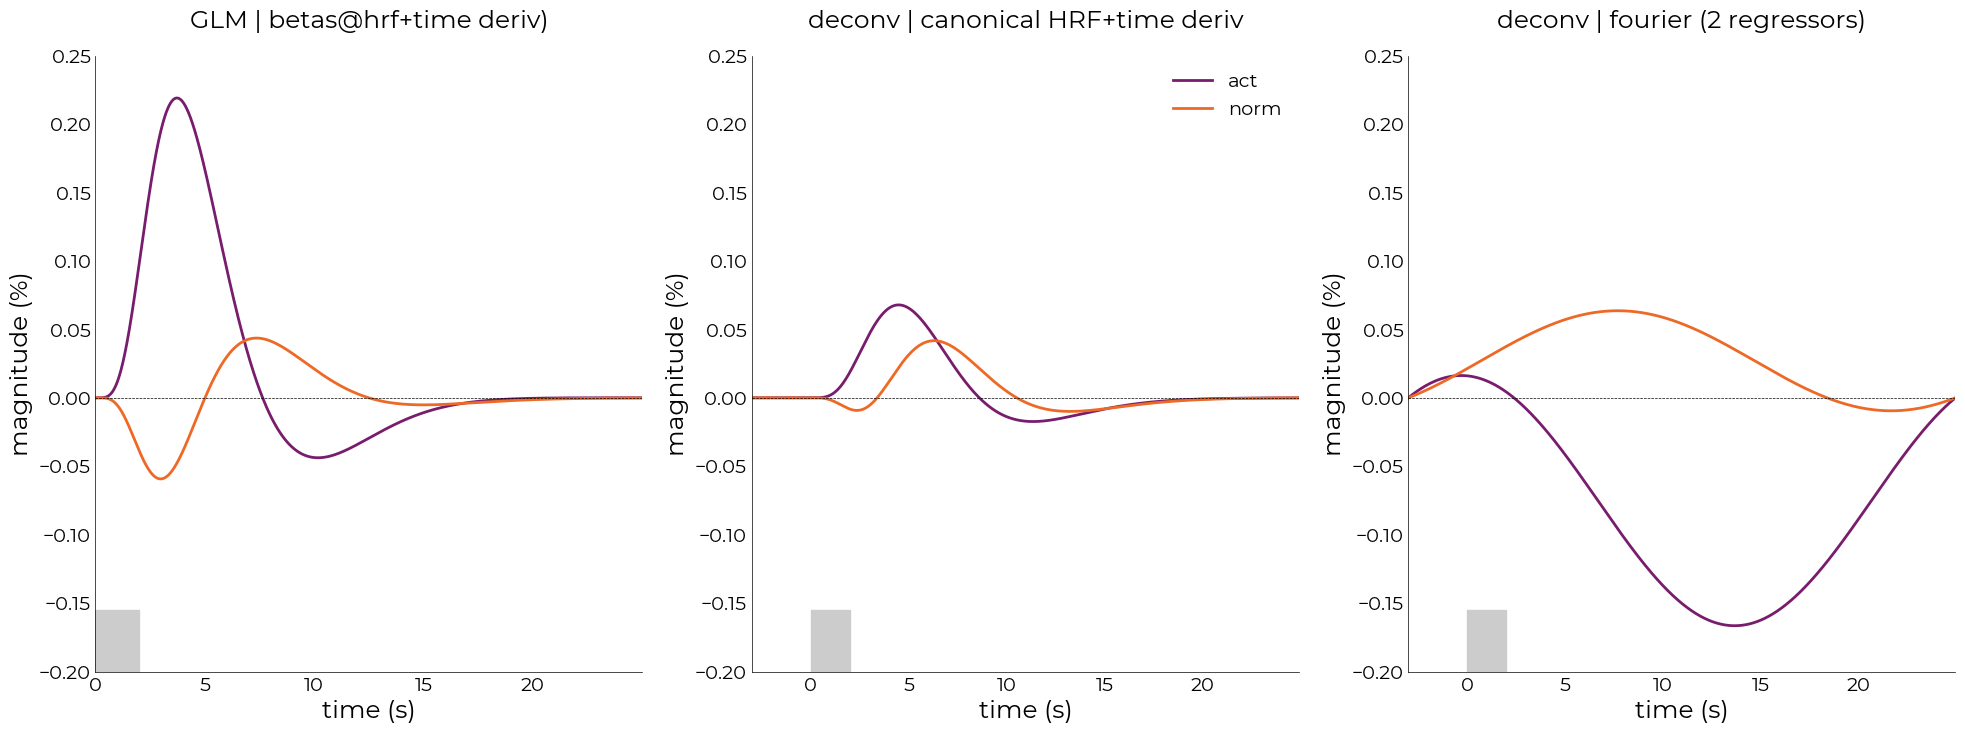

index 2456: [ 1.89222447 -1.99401648  0.85519715  1.30060897  0.          0.32818118
  4.99707334  1.60020773  9.95479949  0.25038806]


In [30]:
%matplotlib inline
fig,axs = plt.subplots(ncols=3, figsize=(24,8))

hrf_act = np.squeeze(np.array(fitter.hrf).T @ fitter.results["betas"][1:3])
hrf_norm = np.squeeze(np.array(fitter.hrf).T @ fitter.results["betas"][3:])

time_axis = list(((np.arange(0,hrf_act.shape[0]))/fitter.osf)*fitter.TR)
y_lim = [-0.2,0.25]
plotting.LazyPlot(
    [hrf_act,hrf_norm],
    xx=time_axis,
    x_label="time (s)",
    y_label="magnitude (%)",
    add_hline='default',
    axs=axs[0],
    title="GLM | betas@hrf+time deriv)",
    line_width=2,
    cmap='inferno',
    y_lim=y_lim)

can_fit.plot_average_per_event(
    x_label="time (s)",
    y_label="magnitude (%)",
    add_hline='default',
    axs=axs[1],
    title="deconv | canonical HRF+time deriv",
    labels=can_fit.cond,
    line_width=2,
    cmap='inferno',
    y_lim=y_lim)

fou_fit.plot_average_per_event(
    x_label="time (s)",
    y_label="magnitude (%)",
    add_hline='default',
    axs=axs[2],
    title=f"deconv | fourier ({fou_fit.n_regressors} regressors)",
    line_width=2,
    cmap='inferno',
    y_lim=y_lim)

# plot stimulus onset
for ax in axs:
    ax.axvspan(0,2, ymax=0.1, color="#cccccc")

In [40]:
can_fit.model.get_rsq()

average
subject run          
008     1    0.014432
        2    0.004264

In [41]:
fou_fit.model.get_rsq()

average
subject run          
008     1    0.041859
        2    0.018112

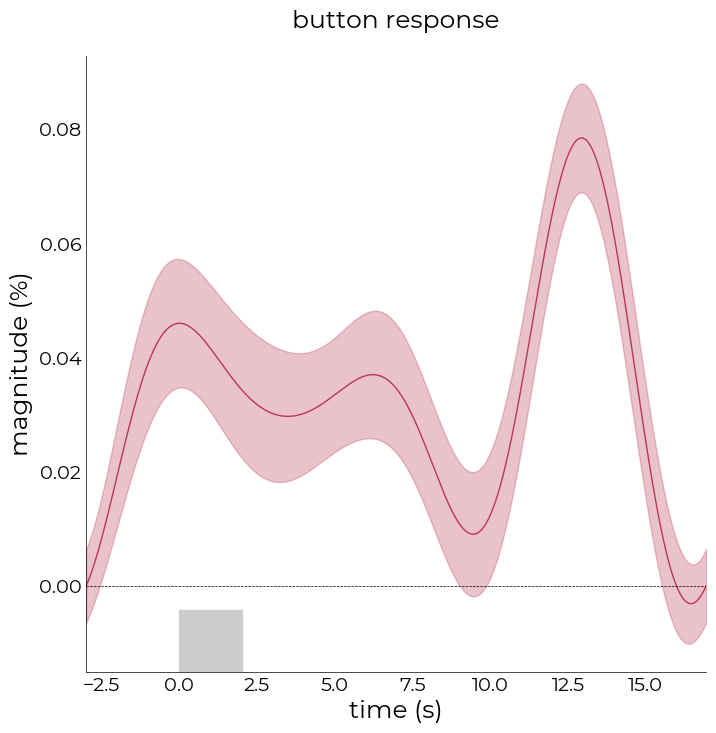

In [170]:
# %matplotlib inline
# fig,axs = plt.subplots(figsize=(8,8))
# fit_button.plot_average_per_event(
#     x_label="time (s)",
#     y_label="magnitude (%)",
#     add_hline='default',
#     axs=axs,
#     title="button response",
#     add_labels=True,
#     fancy=True,
#     fancy_denom=6,
#     inset_ttp=[0.75, 0.8, 0.3],
#     cmap='inferno')

# # plot stimulus onset
# axs.axvspan(0,2, ymax=0.1, color="#cccccc")

### Split events over voxels

In [157]:
df_ribbon.shape

(6400, 6)

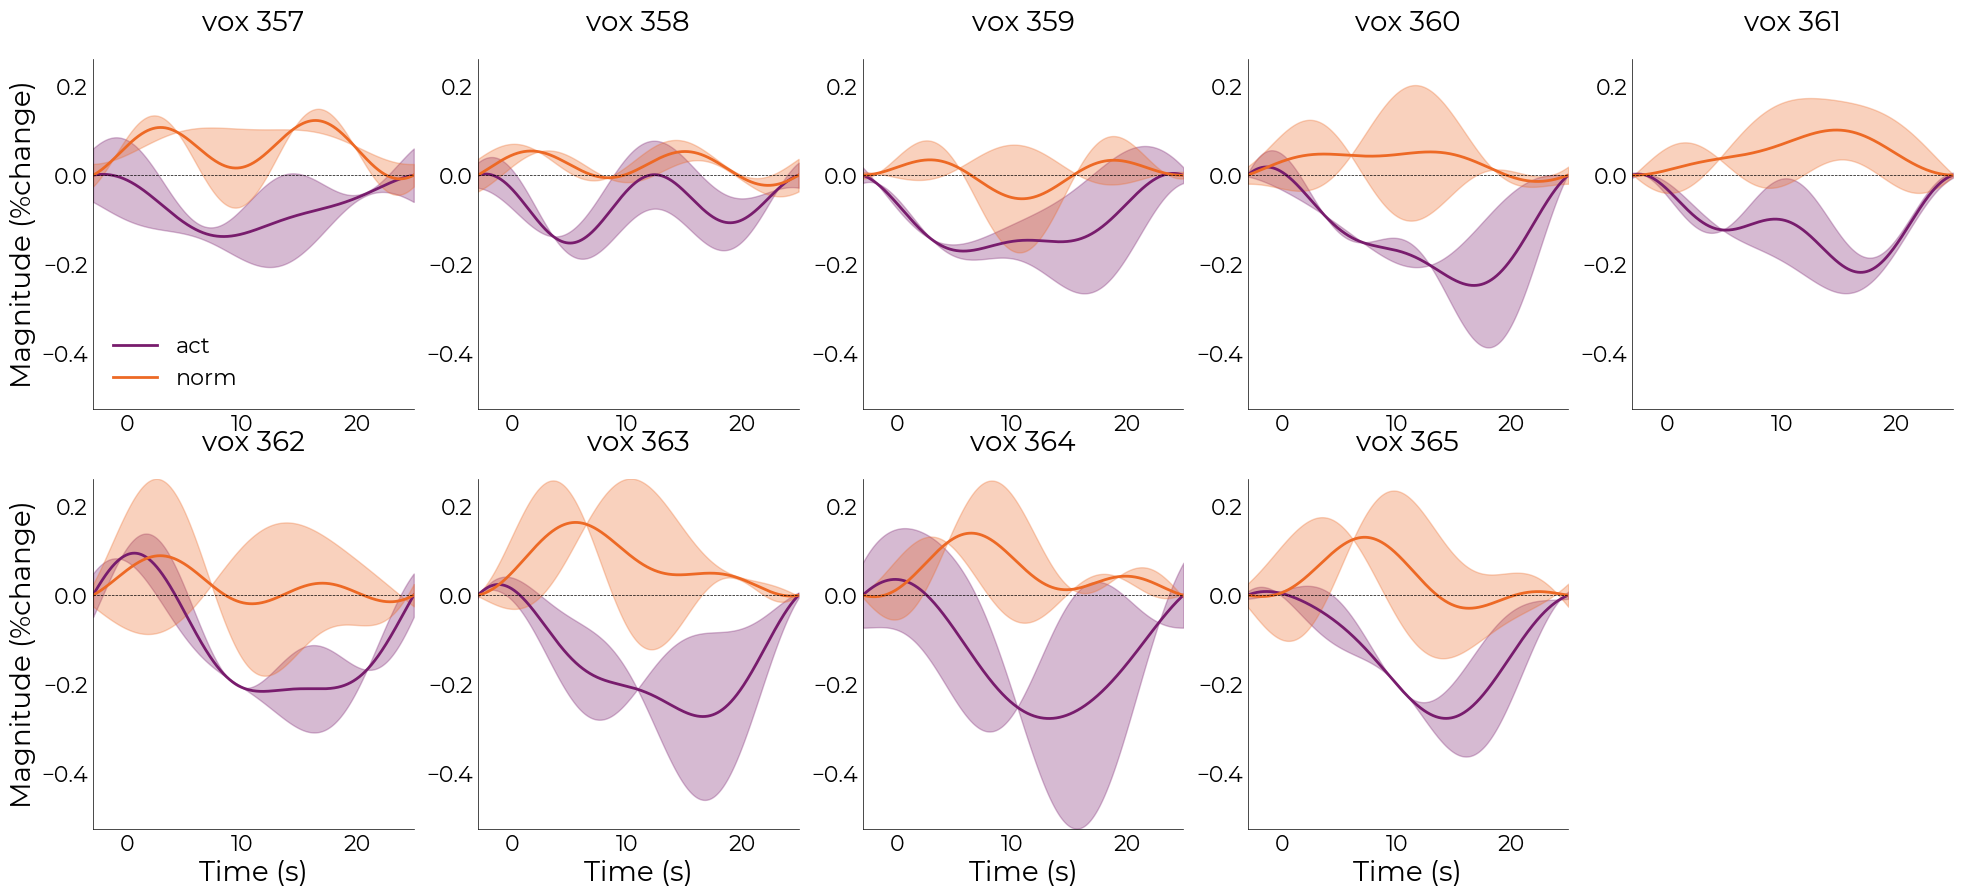

In [39]:
fou_fit.plot_average_per_voxel(
    labels=nd_fit.cond,
    wspace=0.2,
    # n_cols=df_ribbon.shape[-1],
    n_cols=5,
    cmap="inferno",
    line_width=2,
    font_size=20,
    label_size=16,
    sharey=True)
    # save_as=opj(func_dir, "hrf_gamma_voxel.png"))